In [140]:
import pickle
with open('rc_big.pkl', 'rb') as f:
    data = pickle.load(f)

In [175]:
60/112*28

15.0

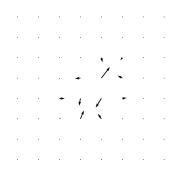

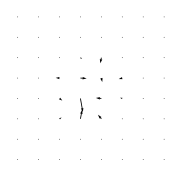

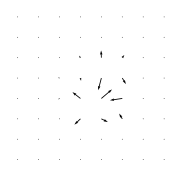

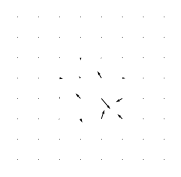

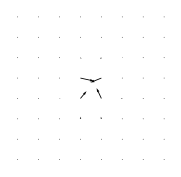

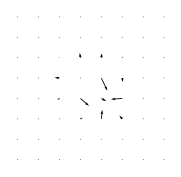

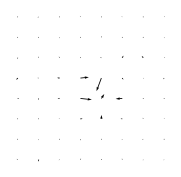

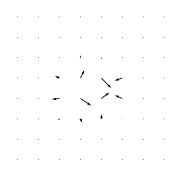

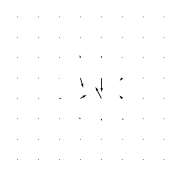

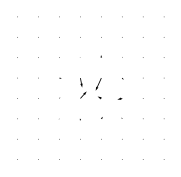

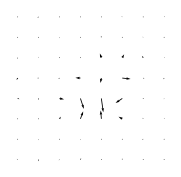

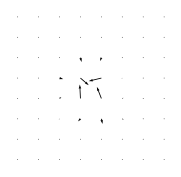

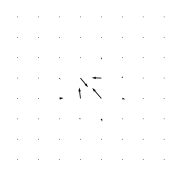

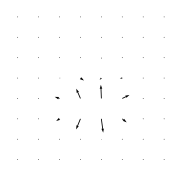

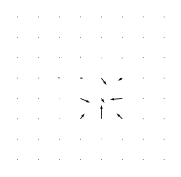

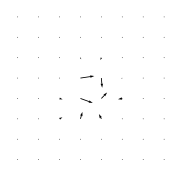

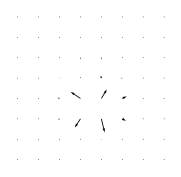

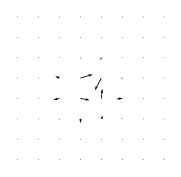

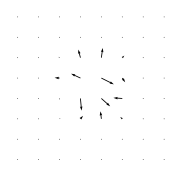

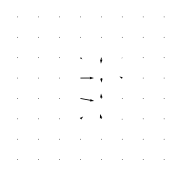

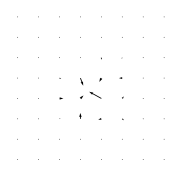

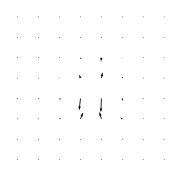

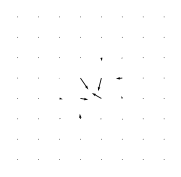

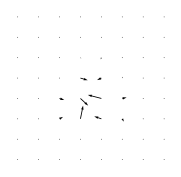

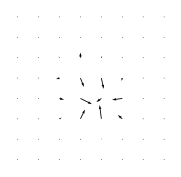

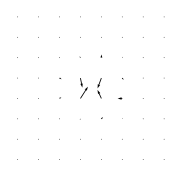

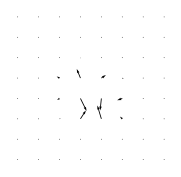

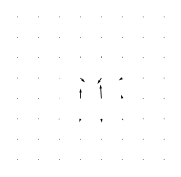

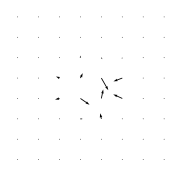

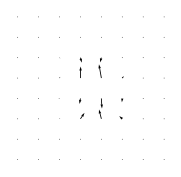

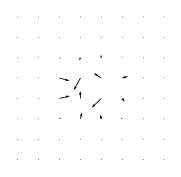

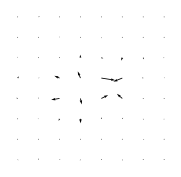

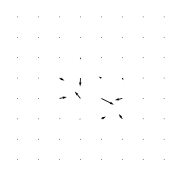

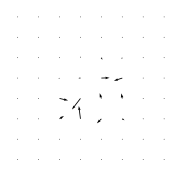

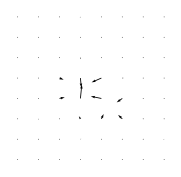

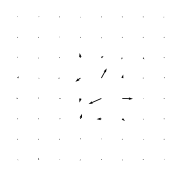

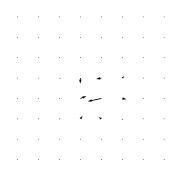

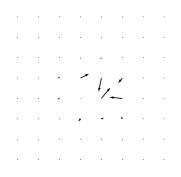

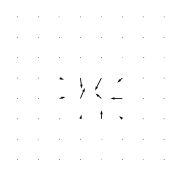

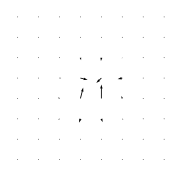

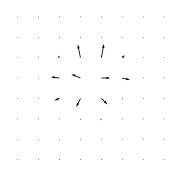

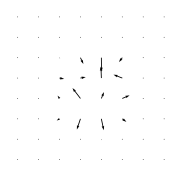

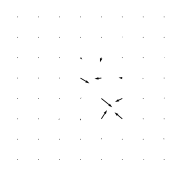

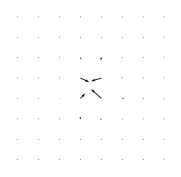

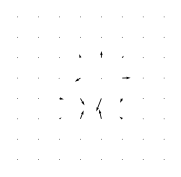

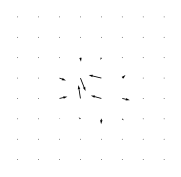

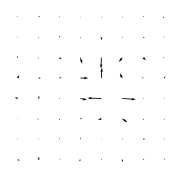

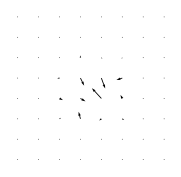

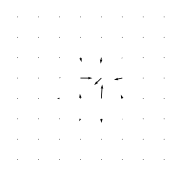

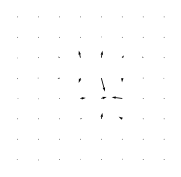

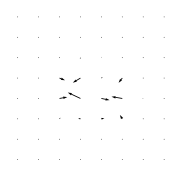

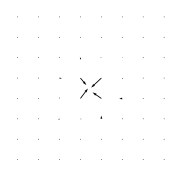

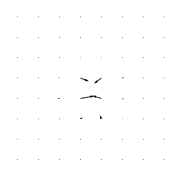

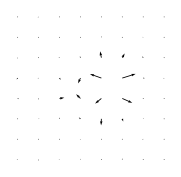

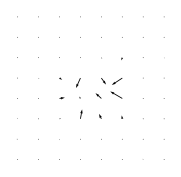

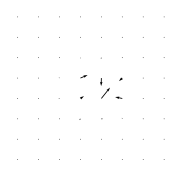

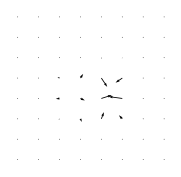

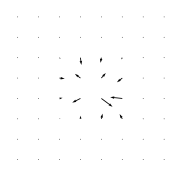

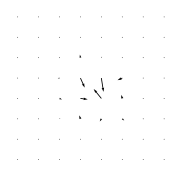

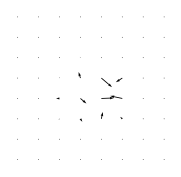

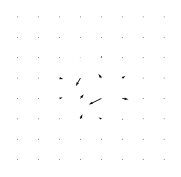

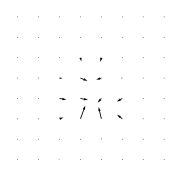

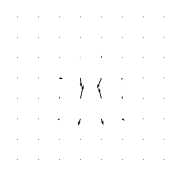

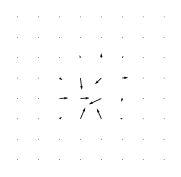

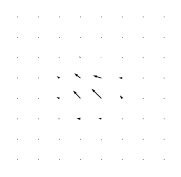

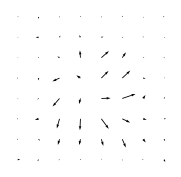

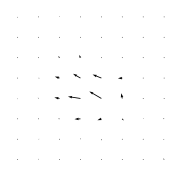

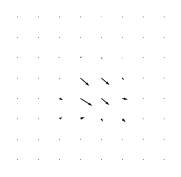

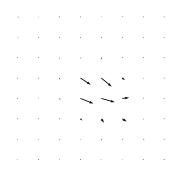

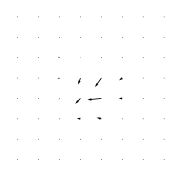

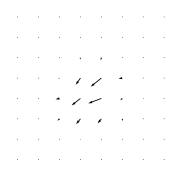

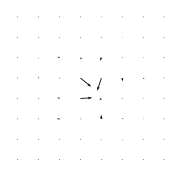

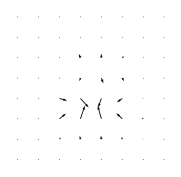

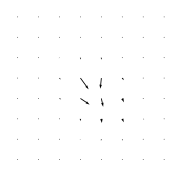

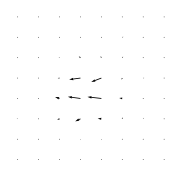

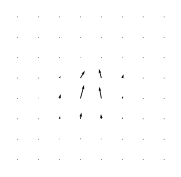

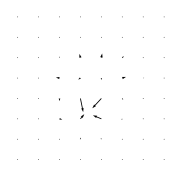

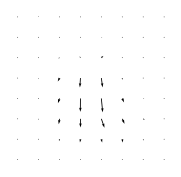

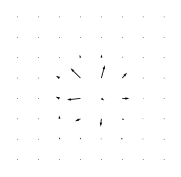

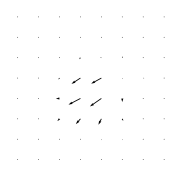

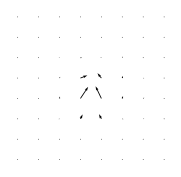

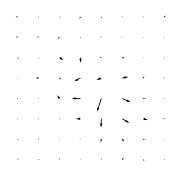

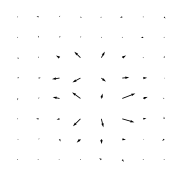

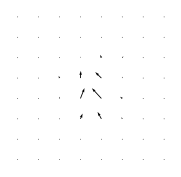

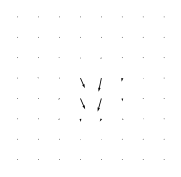

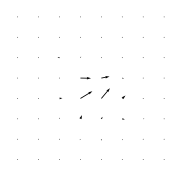

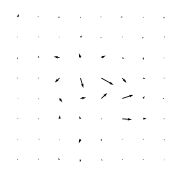

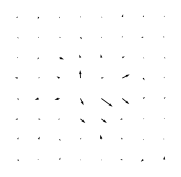

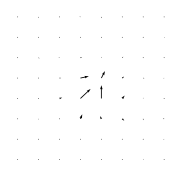

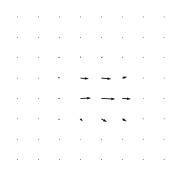

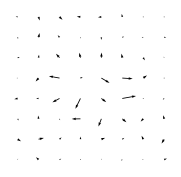

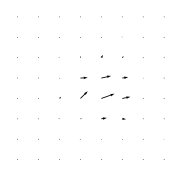

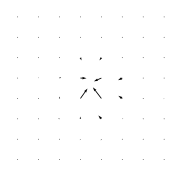

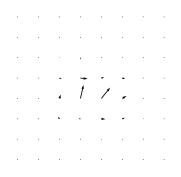

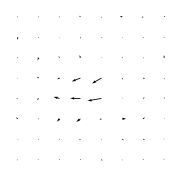

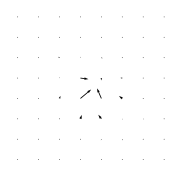

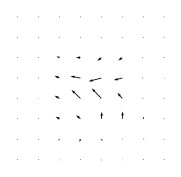

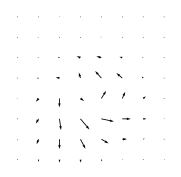

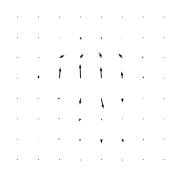

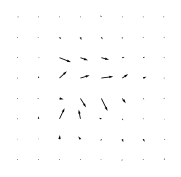

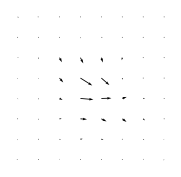

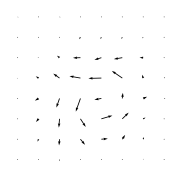

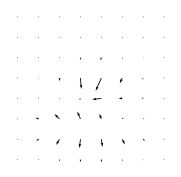

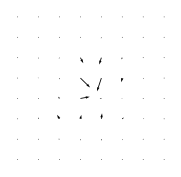

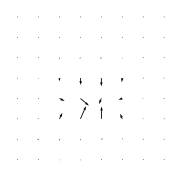

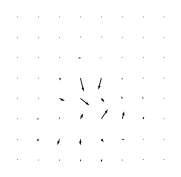

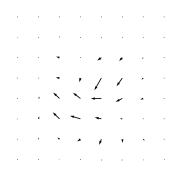

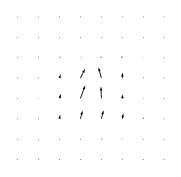

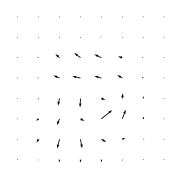

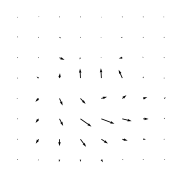

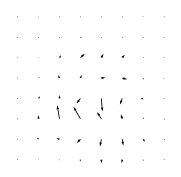

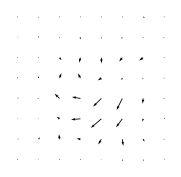

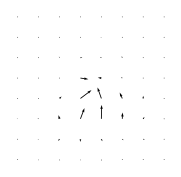

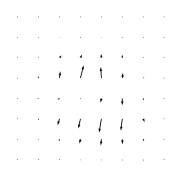

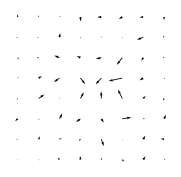

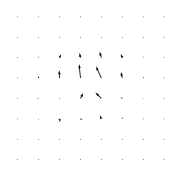

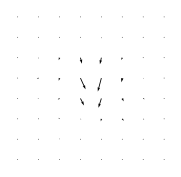

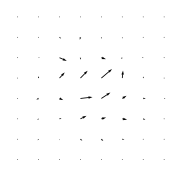

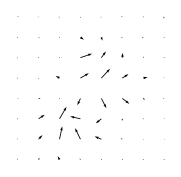

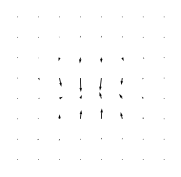

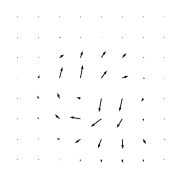

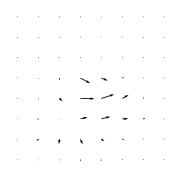

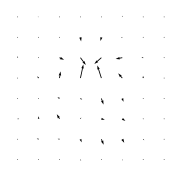

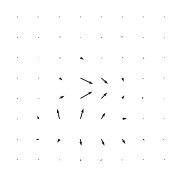

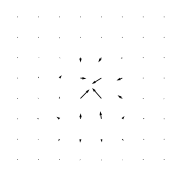

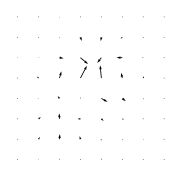

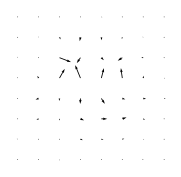

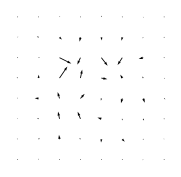

In [178]:
import seaborn as sns
for layer_name, max_filt in [('layer01', 64), ('layer02', 32), ('layer03', 32)]:
    for filt in range(max_filt):
        xx = data[layer_name][filt, :, :, 0]
        yy = data[layer_name][filt, :, :, 1]
        maxa = 12*np.sqrt(xx ** 2 + yy ** 2).max()
        plt.figure(figsize=(3, 3))
        plt.quiver(xx, yy, scale=maxa, width=.005)
        plt.xlim([9.5, 17.5])
        plt.ylim([17.5, 9.5])
        #plt.imshow(data['layer01'][idx, :, :, 0])
        #sns.despine()
        plt.box(False)
        plt.axis(False)
        plt.savefig(f'figures/{features}_{layer_name}_{filt}_quiver.svg')
        plt.savefig(f'figures/{features}_{layer_name}_{filt}_quiver.png')
        plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append("../../CPC/dpc")
sys.path.append("../../CPC/backbone")

from python_dict_wrapper import wrap

features = 'airsim_04'

args = wrap({'features': features,#'airsim_02',
             'ckpt_root': '../pretrained',
             'slowfast_root': '../../slowfast',
             'ntau': 1,
             'subsample_layers': False})

from fmri_models import get_feature_model

model, hooks, data = get_feature_model(args)

In [117]:
model

DorsalNet(
  (s1): ShallowNet(
    (conv1): Conv3d(3, 64, kernel_size=[5, 7, 7], stride=[1, 2, 2], padding=[2, 3, 3], bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    (dropout): Dropout3d(p=0, inplace=False)
  )
  (res0): ResBlock(
    (branch1): Conv3d(64, 32, kernel_size=(1, 1, 1), stride=[1, 1, 1], bias=False)
    (branch1_bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (branch2): BottleneckTransform(
      (a): Conv3d(64, 8, kernel_size=[1, 1, 1], stride=[1, 1, 1], padding=[0, 0, 0], bias=False)
      (a_bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a_relu): ReLU(inplace=True)
      (b): Conv3d(8, 8, kernel_size=[1, 3, 3], stride=[1, 1, 1], padding=[0, 1, 1], dilation=[1

In [139]:
import lucentpatch
import lucentpatch.transform

from lucentpatch.render import render_vis
from lucentpatch.objectives import neuron, slow, tv_slow, intensity_preservation
from lucent.optvis.objectives import channel
from lucent.optvis import param
import lucent
import lucent.optvis
import lucent.optvis.transform

import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def get_anim(result, size=4, norm=False):
    fig = plt.figure(figsize=(size, size))
    ax = plt.gca()
    im = plt.imshow([[1]])
    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0)

    rg = None
    if norm:
        rg = [result.min(), result.max()]

    def drawframe(n):
        if n >= nt:
            n = nt - 1
        else:
            im.set_data(result.transpose((2, 3, 1, 0))[:, :, :, n])
        if norm:
            im.set_clim(rg)
        return (im)

    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, drawframe, frames=nt*2, interval=100, blit=False)
    plt.close()
    return anim

npixels = 60

for layer_name, max_filt in [('s1_pool_layer', 64), ('res0_relu', 32), ('res1_relu', 32)]:
    for filt in range(max_filt):
        nt = 7
        device = 'cuda'

        # Most important layers: layer2_1_relu, layer3_0_relu, layer3_1_relu
        obj = neuron(layer_name, filt, (1, 1)) #+ 2 * slow('input') + 2 * tv_slow('input') #+ 5 * intensity_preservation('input', 112 // 4, 112)

        # sd = None converges faster, but some filters are 0.
        for sd in [None, .1, .15]:
            batch_param_f = lambda: param.image(npixels, batch=nt, fft=False, sd=sd)
            model = model.to(device).eval()
            result = render_vis(model, 
                                obj, 
                                batch_param_f, 
                                show_image=False, 
                                show_inline=False, 
                                thresholds=(512,), 
                                fixed_image_size=True,
                                preprocess=False,
                                transforms=[lucentpatch.transform.normalize(),
                                            lucent.optvis.transform.pad(12, mode="constant", constant_value=0.5),
                                            lucent.optvis.transform.jitter(8),
                                            lucent.optvis.transform.random_scale([1 + (i - 5) / 50.0 for i in range(11)]),
                                            lucent.optvis.transform.random_rotate(list(range(-10, 11)) + 5 * [0]),
                                            lucent.optvis.transform.jitter(4),
                                            #lucentpatch.transform.loop(3)
                                            ],
                                )

            if result[0].std() > .01 or sd == .15: 
                anim = get_anim(result[0], npixels / 72)
                anim.save(f'figures/{features}_{layer_name}_{filt}.gif', writer='imagemagick', fps=12, bitrate=10000)
                plt.imsave(f'figures/{features}_{layer_name}_{filt}.png', result[0][4, :, :, :].transpose((1, 2, 0)))
                break


100%|██████████| 512/512 [00:24<00:00, 20.81it/s]


In [138]:
72*1.5

108.0

In [119]:
#                anim.save(f'figures/{features}_{layer_name}_{filt}.gif', writer='imagemagick', fps=12, bitrate=10000)
#                plt.imsave(f'figures/{features}_{layer_name}_{filt}.png', result[0][4, :, :, :].transpose((1, 2, 0)))
plt.imsave(f'figures/{features}_{layer_name}_{filt}.gif', result[0][:, :, :, :].transpose((2, 3, 1, 0)))

In [128]:
result[0].min()

0.010803334

In [134]:
from PIL import Image, ImageDraw
images = []
for i in range(result[0].shape[0]):
    images.append(Image.fromarray((255*result[0][i, :, :, :]).astype(np.uint8).transpose((1, 2, 0))))

for j in range(2):
    images.append(Image.fromarray((255*result[0][i, :, :, :]).astype(np.uint8).transpose((1, 2, 0))))
    
images[0].save(f'figures/{features}_{layer_name}_{filt}.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)


In [116]:

#plt.imshow()

Signature: plt.imsave(fname, arr, **kwargs)
Docstring:
Save an array as an image file.

Parameters
----------
fname : str or path-like or file-like
    A path or a file-like object to store the image in.
    If *format* is not set, then the output format is inferred from the
    extension of *fname*, if any, and from :rc:`savefig.format` otherwise.
    If *format* is set, it determines the output format.
arr : array-like
    The image data. The shape can be one of
    MxN (luminance), MxNx3 (RGB) or MxNx4 (RGBA).
vmin, vmax : float, optional
    *vmin* and *vmax* set the color scaling for the image by fixing the
    values that map to the colormap color limits. If either *vmin*
    or *vmax* is None, that limit is determined from the *arr*
    min/max value.
cmap : str or `~matplotlib.colors.Colormap`, default: :rc:`image.cmap`
    A Colormap instance or registered colormap name. The colormap
    maps scalar data to colors. It is ignored for RGB(A) data.
format : str, optional
    The 

In [59]:
result[0].std()

0.09828022

In [56]:
result[0].min()

0.49366614

In [60]:
import napari
viewer = napari.Viewer()
viewer.add_image(result[0].transpose((0, 2, 3, 1)), name='data', rgb=True)

<Image layer 'data' at 0x7f3b0f8c12e0>

100%|██████████| 128/128 [00:08<00:00, 14.72it/s]


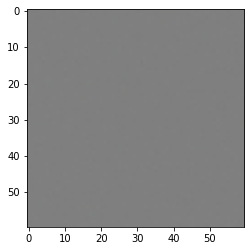

In [48]:
filt = 2

batch_param_f = lambda: param.image(60, batch=nt, fft=False, sd=None)

obj = neuron(layer_name, filt, (1, 1)) #+ 2 * slow('input') + 2 * tv_slow('input') #+ 5 * intensity_preservation('input', 112 // 4, 112)

result = render_vis(model, 
                    obj, 
                    batch_param_f, 
                    show_image=False, 
                    show_inline=False, 
                    thresholds=(128,), 
                    fixed_image_size=True,
                    preprocess=False,
                    transforms=[lucentpatch.transform.normalize(),
                                lucent.optvis.transform.pad(12, mode="constant", constant_value=0.5),
                                lucent.optvis.transform.jitter(8),
                                lucent.optvis.transform.random_scale([1 + (i - 5) / 50.0 for i in range(11)]),
                                lucent.optvis.transform.random_rotate(list(range(-10, 11)) + 5 * [0]),
                                lucent.optvis.transform.jitter(4),
                                #lucentpatch.transform.loop(3)
                                ],
                    )


plt.imshow(result[0][3, ...].transpose((2, 1, 0)))

0.0015169687

In [23]:
result[0].shape

(7, 3, 60, 60)

In [5]:
112/2+10

66.0

In [6]:
from lucent.optvis.param.spatial import pixel_image, fft_image
from lucent.optvis.param.color import to_valid_rgb

import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def deformed_image(w, h=None, sd=None, batch=None, decorrelate=True,
          fft=True, channels=None):
    if sd is None:
        sd = .01
        
    h = h or w
    batch = batch or 1
    ch = channels or 3
    shape = [1, ch, h, w]
    param_f = fft_image if fft else pixel_image
    params, image_f = param_f(shape, sd=sd)
    
    print(shape)
    #d = (torch.randn(1, h, w, 2) * sd).to(device).requires_grad_(True)
    dxy = (torch.randn(1, h // 8, w // 8, 2) * .0000001).to(device).requires_grad_(True)
    
    xi, yi = torch.meshgrid(torch.linspace(-1, 1, h), torch.linspace(-1, 1, h))
    g = torch.stack([yi, xi], dim=2)
    g = g.to(device=device).unsqueeze(0)
    
    def get_output():
        a = image_f()
        outputs = []
        for i in range(batch):
            # Upsample the displacement grid
            dxy_big = F.grid_sample(dxy.permute(0, 3, 1, 2), g, align_corners=True)
            dxy_big = dxy_big.permute(0, 2, 3, 1)
            the_im = F.grid_sample(a, 
                                   g + dxy_big * (i - batch // 2), 
                                   align_corners=True, 
                                   padding_mode='zeros')
            outputs.append(the_im)
        out = torch.cat(outputs, axis=0)
        return out
    
    return params + [dxy], get_output

batch_param_f = lambda: deformed_image(60, batch=nt, fft=False)

result = render_vis(model, 
                    obj, 
                    batch_param_f, 
                    show_image=False, 
                    show_inline=False, 
                    thresholds=(128,), 
                    fixed_image_size=True,
                    preprocess=False,
                    transforms=[],
                    )

#anim.save(f'figures/{layer_name}_{filt}.gif', writer='imagemagick', fps=12, bitrate=10000)
#HTML(anim.to_html5_video())
#anim.min()
#params, output = batch_param_f()
#plt.subplot(121)
#plt.imshow(params[0].cpu().detach().numpy()[0, :, :, :].transpose((1, 2, 0))*10 + .5)
#plt.subplot(122)
#plt.imshow(output().cpu().detach().numpy()[3, :, :, :].transpose((1, 2, 0))*10 + .5)
#params[0].shape

#anim = get_anim(result[0]*.1+.5)
#HTML(anim.to_html5_video())

  3%|▎         | 4/128 [00:00<00:03, 39.67it/s]

[1, 3, 60, 60]


100%|██████████| 128/128 [00:02<00:00, 44.43it/s]
